# Imports

In [53]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Utilities

In [3]:
def extract_metadata(base_dir):
    data = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".nii.gz"):
                file_path = os.path.join(root, file)
                path_parts = file_path.split(os.sep)
                patient_id = path_parts[-3]
                appointment_number = path_parts[-2]

                # Extract the scan type and instance number (including cases like _1a, _1b)
                match = re.match(r'([A-Za-z0-9_]+?)(?:_([0-9a-zA-Z]+))?\.nii\.gz', file)
                if match:
                    scan_type = match.group(1)
                    instance = match.group(2) if match.group(2) else '0'
                else:
                    scan_type = 'Unknown'
                    instance = '0'

                data.append({
                    "PatientID": patient_id,
                    "AppointmentNumber": appointment_number,
                    "ScanType": scan_type,
                    "Instance": instance,
                    "FilePath": file_path
                })

    df = pd.DataFrame(data)
    # Ensure AppointmentNumber is stored as an object (string)
    df['AppointmentNumber'] = df['AppointmentNumber'].astype(str)
    # Sort the dataframe by PatientID, AppointmentNumber, ScanType, and Instance
    df = df.sort_values(by=['PatientID', 'AppointmentNumber', 'ScanType', 'Instance']).reset_index(drop=True)
    return df

In [32]:
def appointment_counts(metadata_df):
    appointment_counts = metadata_df.groupby('PatientID')['AppointmentNumber'].nunique()

    # Count the number of patients for each appointment count
    appointment_distribution = appointment_counts.value_counts().sort_index()

    # Plot the distribution
    plt.figure(figsize=(5, 3))
    appointment_distribution.plot(kind='bar', edgecolor='black')
    plt.xlabel('Number of Appointments')
    plt.ylabel('Number of Patients')
    plt.title('Distribution of Appointments Across Patients')
    plt.grid(axis='y')
    plt.show()

    appointment_counts_df = appointment_distribution.reset_index(name='Number of Patients').rename(columns={'index': 'Number of Appointments'})
    return appointment_counts_df

In [34]:
def scan_type_counts(metadata_df):
    scan_type_counts = metadata_df['ScanType'].value_counts().sort_index()

    # Plot the distribution
    plt.figure(figsize=(5, 3))
    scan_type_counts.plot(kind='bar', edgecolor='black')
    plt.xlabel('Scan Type')
    plt.ylabel('Count')
    plt.title('Distribution of Scan Types')
    plt.grid(axis='y')
    plt.show()

    scan_type_counts_df = scan_type_counts.reset_index(name='Count').rename(columns={'index': 'Scan Type'})
    scan_type_counts_df = scan_type_counts_df.sort_values(by=['Count'],ascending=False)

    return scan_type_counts_df

In [71]:
def scan_type_counts_by_patient(metadata_df):

    # Count the number of each scan type by patient
    scan_type_counts_by_patient = metadata_df.groupby('ScanType')['PatientID'].nunique().sort_values(ascending=False)

    # Plot the distribution
    plt.figure(figsize=(5, 3))
    scan_type_counts_by_patient.plot(kind='bar', edgecolor='black')
    plt.xlabel('Scan Type')
    plt.ylabel('Number of Patients')
    plt.title('Distribution of Scan Types by Number of Patients')
    plt.grid(axis='y')
    plt.show()

    # Return the table of scan type counts by patient
    scan_type_counts_by_patient = scan_type_counts_by_patient.reset_index(name='Number of Patients').rename(columns={'ScanType': 'Scan Type'})

    return scan_type_counts_by_patient

In [41]:
def patients_without_scan_type(df, scan_type):
    # Identify patients who do not have the specified scan type
    patients_with_scan = df[df['ScanType'] == scan_type]['PatientID'].unique()
    all_patients = df['PatientID'].unique()
    patients_without_scan = set(all_patients) - set(patients_with_scan)
    
    # List appointments for these patients
    result = df[df['PatientID'].isin(patients_without_scan)][['PatientID', 'AppointmentNumber']].drop_duplicates()
    
    return result

In [83]:
def patients_without_scan_type(df, scan_type):
# Identify patients who do not have the specified scan type
    patients_with_scan = df[df['ScanType'] == scan_type]['PatientID'].unique()
    all_patients = df['PatientID'].unique()
    patients_without_scan = set(all_patients) - set(patients_with_scan)
    
    # List patients for whom all appointments are missing the scan type
    complete_missing_patients = df[df['PatientID'].isin(patients_without_scan)]['PatientID'].drop_duplicates().to_frame()
    complete_missing_patients['AppointmentNumber'] = 'all'
    
    # List specific appointments for patients with some but not all appointments missing the scan type
    partial_missing_patients = set(all_patients) - set(patients_without_scan)
    partial_missing_appointments = df[df['PatientID'].isin(partial_missing_patients)]
    
    # Identify appointments that do not have the specified scan type
    appointments_with_scan = partial_missing_appointments[partial_missing_appointments['ScanType'] == scan_type]
    appointments_with_scan_set = set(zip(appointments_with_scan['PatientID'], appointments_with_scan['AppointmentNumber']))
    all_appointments_set = set(zip(partial_missing_appointments['PatientID'], partial_missing_appointments['AppointmentNumber']))
    appointments_without_scan_set = all_appointments_set - appointments_with_scan_set
    
    # Create DataFrame for partial missing appointments
    partial_missing_df = pd.DataFrame(appointments_without_scan_set, columns=['PatientID', 'AppointmentNumber'])
    
    # Combine the two lists
    combined_df = pd.concat([complete_missing_patients, partial_missing_df], ignore_index=True)
    
    # Sort by PatientID
    combined_df = combined_df.sort_values(by=['PatientID', 'AppointmentNumber'])
    
    return combined_df

In [59]:
def display_scrollable_dataframe(df):
    return df.style.set_table_attributes('style="max-height:300px; max-width:300px; display:block; overflow:auto;"').format(precision=2)

# Dataset

In [4]:
# setup project directory
dir_base = '/data/qte4288/Tumor-Risk-Prediction/'
dir_data = os.path.join(dir_base, 'data/NIFTI')

In [5]:
metadata_df = extract_metadata(dir_data)
metadata_df.info()
metadata_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3917 entries, 0 to 3916
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   PatientID          3917 non-null   object
 1   AppointmentNumber  3917 non-null   object
 2   ScanType           3917 non-null   object
 3   Instance           3917 non-null   object
 4   FilePath           3917 non-null   object
dtypes: object(5)
memory usage: 153.1+ KB


,PatientID,AppointmentNumber,ScanType,Instance,FilePath
0,PT0001,01,FLAIR,1,/data/qte4288/Tumor-Risk-Prediction/data/NIFTI...
1,PT0001,01,T1CE_GE,1,/data/qte4288/Tumor-Risk-Prediction/data/NIFTI...
2,PT0001,01,T1CE_SE,1,/data/qte4288/Tumor-Risk-Prediction/data/NIFTI...
3,PT0001,01,T1_SE,1,/data/qte4288/Tumor-Risk-Prediction/data/NIFTI...
4,PT0001,01,T2,1,/data/qte4288/Tumor-Risk-Prediction/data/NIFTI...


In [6]:
metadata_df

,PatientID,AppointmentNumber,ScanType,Instance,FilePath
0,PT0001,01,FLAIR,1,/data/qte4288/Tumor-Risk-Prediction/data/NIFTI...
1,PT0001,01,T1CE_GE,1,/data/qte4288/Tumor-Risk-Prediction/data/NIFTI...
2,PT0001,01,T1CE_SE,1,/data/qte4288/Tumor-Risk-Prediction/data/NIFTI...
3,PT0001,01,T1_SE,1,/data/qte4288/Tumor-Risk-Prediction/data/NIFTI...
4,PT0001,01,T2,1,/data/qte4288/Tumor-Risk-Prediction/data/NIFTI...
...,...,...,...,...,...
3912,PT0096,07,FLAIR,1,/data/qte4288/Tumor-Risk-Prediction/data/NIFTI...
3913,PT0096,07,T1,1,/data/qte4288/Tumor-Risk-Prediction/data/NIFTI...
3914,PT0096,07,T1CE_GE,1,/data/qte4288/Tumor-Risk-Prediction/data/NIFTI...
3915,PT0096,07,T1_GE,1,/data/qte4288/Tumor-Risk-Prediction/data/NIFTI...


In [47]:
# Save to a CSV file
# metadata_df.to_csv("/home/qte4288/Projects/Tumor-Risk-Prediction/data/metadata.csv", index=False)

# Data Statistics

In [8]:
# Total number of patients
total_patients = metadata_df['PatientID'].nunique()
print("Total Patients: ", total_patients)

Total Patients:  96


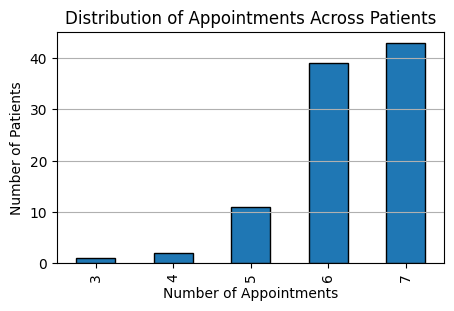

,AppointmentNumber,Number of Patients
0,3,1
1,4,2
2,5,11
3,6,39
4,7,43


In [33]:
# Count the number of appointments per patient
appointment_counts_df = appointment_counts(metadata_df)
appointment_counts_df

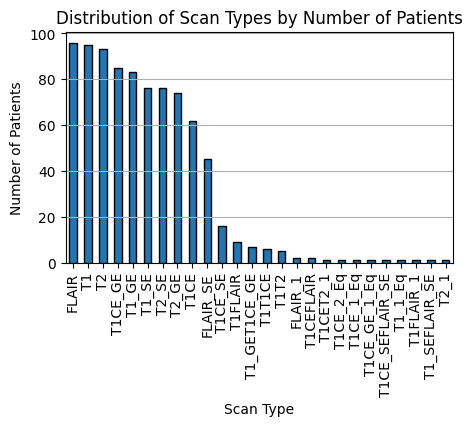

,Scan Type,Number of Patients
0,FLAIR,96
1,T1,95
2,T2,93
3,T1CE_GE,85
4,T1_GE,83
5,T1_SE,76
6,T2_SE,76
7,T2_GE,74
8,T1CE,62
9,FLAIR_SE,45


In [74]:
scan_type_counts = scan_type_counts_by_patient(metadata_df)
display(display_scrollable_dataframe(scan_type_counts))

## Missing Data

In [84]:
# Generate the list of patients and their appointments that do not have FLAIR scans
missing_scans = patients_without_scan_type(metadata_df, 'FLAIR')
display(display_scrollable_dataframe(missing_scans))

,PatientID,AppointmentNumber
14,PT0003,03
10,PT0003,04
34,PT0003,05
37,PT0003,06
59,PT0007,01
24,PT0007,04
67,PT0009,03
17,PT0010,04
1,PT0011,03
66,PT0015,01


In [82]:
# Generate the list of patients and their appointments that do not have T1 scans
missing_scans = patients_without_scan_type(metadata_df, 'T1')
display(display_scrollable_dataframe(missing_scans))

,PatientID,AppointmentNumber
0,PT0063,all
1,PT0012,05
2,PT0079,07
3,PT0068,05
4,PT0041,03
5,PT0092,06
6,PT0015,02
7,PT0031,05
8,PT0009,06
9,PT0052,02


In [61]:
# Generate the list of patients and their appointments that do not have T2 scans
missing_scans = patients_without_scan_type(metadata_df, 'T2')
display(display_scrollable_dataframe(missing_scans))

,PatientID,AppointmentNumber
2218,PT0056,01
2222,PT0056,02
2230,PT0056,03
2236,PT0056,04
2244,PT0056,05
2250,PT0056,06
2476,PT0062,01
2481,PT0062,02
2488,PT0062,03
2494,PT0062,04


In [60]:
# Generate the list of patients and their appointments that do not have T1CE_GE scans
missing_scans = patients_without_scan_type(metadata_df, 'T1CE_GE')
display(display_scrollable_dataframe(missing_scans))

,PatientID,AppointmentNumber
257,PT0008,01
263,PT0008,02
270,PT0008,03
277,PT0008,04
284,PT0008,05
289,PT0008,06
477,PT0014,01
483,PT0014,02
489,PT0014,03
496,PT0014,04


In [75]:
# Generate the list of patients and their appointments that do not have T1CE_GE scans
missing_scans = patients_without_scan_type(metadata_df, 'T1_GE')
display(display_scrollable_dataframe(missing_scans))

,PatientID,AppointmentNumber
0,PT0001,01
5,PT0001,02
8,PT0001,03
13,PT0001,04
18,PT0001,05
23,PT0001,06
155,PT0005,01
160,PT0005,02
168,PT0005,03
173,PT0005,04
